In [1]:
#------------------------------------------------------------------------------------------------
#  Copyright (c) Shell Global Solutions International B.V. All rights reserved.
#  Licensed under the MIT License. See License.txt in the project root for license information.
#------------------------------------------------------------------------------------------------

# Benchmark 4: Unsteady-state imbibition without capillary pressure (Buckley-Leverett)

This notebook shows the comparison of 1D2P solver results (as discussed in [1], section 3.3 and figure 5) to literature reference data [2]. 

References:

1. Simultaneous determination of relative permeability and capillary pressure from an unsteady-state core flooding experiment? 
Steffen Berg, Harm Dijk, Evren Unsal, Ronny Hofmann, Bochao Zhao, Vishal Raju Ahuja,
https://doi.org/10.1016/j.compgeo.2024.106091


2. COMPARISON OF FOUR NUMERICAL SIMULATORS FOR SCAL EXPERIMENTS,
Roland Lenormand, Kjetil Lorentzen, Jos G. Maas and Douglas Ruth, SCA2016-006
https://www.jgmaas.com/SCA/2016/SCA2016-006.pdf


SCORES reference data used below have been downloaded (with permission for usage in this benchmark given by Jos Maas, email 21 September 2023) from https://www.jgmaas.com.

Created on 10.02.2024 by Harm Dijk, Steffen Berg

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns # we use seaborn to get nice plots (can be left out)
sns.set_style('whitegrid')
import numpy as np
import pandas as pd

In [3]:
from scallib001.displacementmodel1D2P001 import DisplacementModel1D2P # the solver
import scallib001.relpermlib001 as rlplib # relperm and capillary pressure library

## Read the SCORES model and simulated data

We make use of a dedicated python script to extract data from Excel spreadsheets. The script formats data and converts units ready for use with 1D2P.

In [4]:
from scores_benchmark_data.read_scores_data import read_scores_data

In [5]:
CASE_LABEL = 'Case4 Unsteady-state imbibition without capillary pressure (Buckley-Leverett)' # this will be used in plot title

EXCEL_FILE = 'Case_4_SCA_SCORES.csv'

In [6]:
scores = read_scores_data( directory='scores_benchmark_data', excel_file_name=EXCEL_FILE )

Read scores data file Case_4_SCA_SCORES.csv ...
   Unit conversions applied on data to change from scores to scallib conventions:
    - all fluid density data to kg/m3
    - all flow rate data to cm3/min
    - all time axis data to hour
Data converted.


In [7]:
scores.print_summary()

Summary of scores data:

Excel file: Case_4_SCA_SCORES.csv

excel_file_name : Case_4_SCA_SCORES.csv
Gridblocks : 100
VertHor : H
gravity_multiplier : 0.0
LevJ : OFF
Core_length : 8.0
Core_diam : 4.0
Core_area : 12.566370614359172
Porosity : 0.25
Permeability : 100.0
Flooding :  Imbibition 
Swi : 0.20001
Water_density : 1000.0
Oil_density : 800.0
Water_visc : 1.0
Oil_visc : 1.0
IFT : 0.03
T_end_HOUR : 1.1
Start_timestep_SEC : 0.1
Max_timestep_MIN : 10.0
Max_sat_change : 0.01
Max_incr : 1.2

Dataframe sw_krw :


,Sw,krw
0,0.2000,0.000000
1,0.2122,0.000004
2,0.2245,0.000034
3,0.2367,0.000115
4,0.2490,0.000272
...,...,...
45,0.7510,0.387300
46,0.7633,0.413700
47,0.7755,0.441200
48,0.7878,0.470000


Dataframe sw_kro :


,Sw,kro
0,0.2000,0.500000
1,0.2122,0.470000
2,0.2245,0.441200
3,0.2367,0.413700
4,0.2490,0.387300
...,...,...
45,0.7510,0.000272
46,0.7633,0.000115
47,0.7755,0.000034
48,0.7878,0.000004


Dataframe sw_pc :


,Sw,Pc
0,0.2,0.0
1,0.8,0.0


Dataframe schedule :


,StartTime,InjRate,FracFlow
0,0.0,3.333333,1.0


Dataframe result_data :


,INDEX,Time,Meansat,Pinj_wat,Pprod_wat,Pinj_oil,Pprod_oil,Delta_Pwat,delta_Poil,qwat_inj,qoil_inj,qoil_prod,qwat_prod,Nliq_inj,Noil_prod,Nwat_prod,Dp
0,1.0,0.000028,0.200063,100.7172,100.0008,100.7172,100.0008,0.716455,0.716455,3.333333,0.0,3.333333,1.559796e-14,0.005556,0.005556,2.599660e-17,0.720142
1,2.0,0.000029,0.200065,100.7172,100.0008,100.7172,100.0008,0.716477,0.716477,3.333333,0.0,3.333333,1.559796e-14,0.005761,0.005761,2.695778e-17,0.720209
2,3.0,0.000030,0.200067,100.7173,100.0008,100.7173,100.0008,0.716504,0.716504,3.333333,0.0,3.333333,1.559796e-14,0.005982,0.005982,2.798990e-17,0.720264
3,4.0,0.000031,0.200070,100.7173,100.0008,100.7173,100.0008,0.716537,0.716537,3.333333,0.0,3.333333,1.559796e-14,0.006220,0.006220,2.910587e-17,0.720309
4,5.0,0.000032,0.200074,100.7173,100.0008,100.7173,100.0008,0.716577,0.716577,3.333333,0.0,3.333333,1.559796e-14,0.006480,0.006480,3.032197e-17,0.720343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,2302.0,0.613197,0.733280,101.0217,100.0012,101.0217,100.0012,1.020485,1.020485,3.333333,0.0,0.019377,3.313956e+00,122.639400,13.419720,1.092197e+02,1.022485
2302,2303.0,0.724675,0.737462,100.9980,100.0012,100.9980,100.0012,0.996756,0.996756,3.333333,0.0,0.015634,3.317699e+00,144.935000,13.524290,1.314107e+02,0.998717
2303,2304.0,0.858448,0.741488,100.9757,100.0012,100.9757,100.0012,0.974568,0.974568,3.333333,0.0,0.012545,3.320789e+00,171.689700,13.624970,1.580647e+02,0.976494
2304,2305.0,1.018977,0.745353,100.9550,100.0011,100.9550,100.0011,0.953890,0.953890,3.333333,0.0,0.010032,3.323301e+00,203.795300,13.721600,1.900737e+02,0.955783


## Check some data coming from SCORES

- relperms and capillary pressure

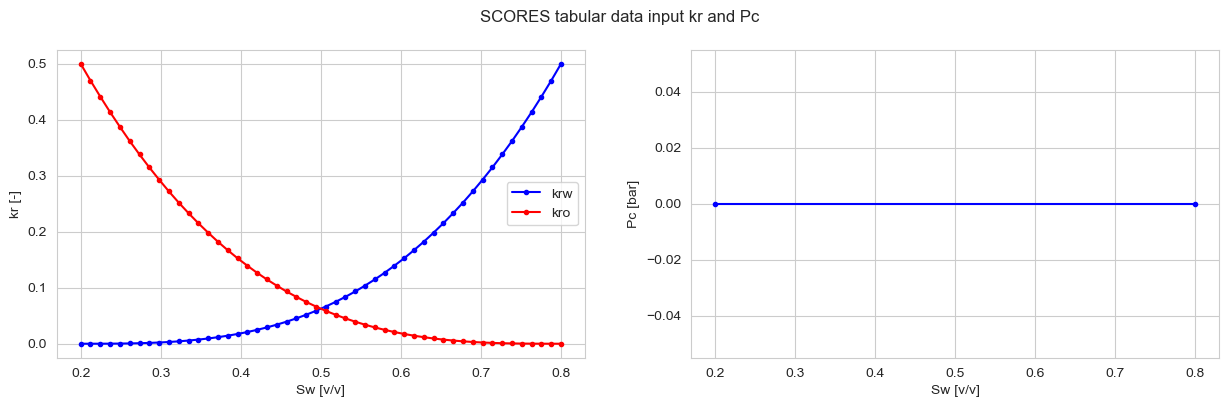

In [8]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( scores.sw_krw.Sw, scores.sw_krw.krw, 'b.-', label='krw')
plt.plot( scores.sw_kro.Sw, scores.sw_kro.kro, 'r.-', label='kro')
plt.ylabel('kr [-]')
plt.xlabel('Sw [v/v]');
plt.legend()

plt.subplot(1,2,2)
plt.plot( scores.sw_pc.Sw, scores.sw_pc.Pc, 'b.-');
plt.ylabel('Pc [bar]')
plt.xlabel('Sw [v/v]');

plt.suptitle('SCORES tabular data input kr and Pc');

# Convert to input for 1D2P

## Define a water-oil relperm model based on SCORES tabular data

- we use monotonic cubic interpolation of the tabular data, i.e., Rlp2PCubic from rlplib

In [9]:
rlp_model1 = rlplib.Rlp2PCubic( scores.sw_krw.Sw.values, 
                                scores.sw_krw.krw.values, 
                                scores.sw_kro.kro.values, 
                                lex=0, # no left extrapolation
                                rex=0, # no right extrapolation
                              )

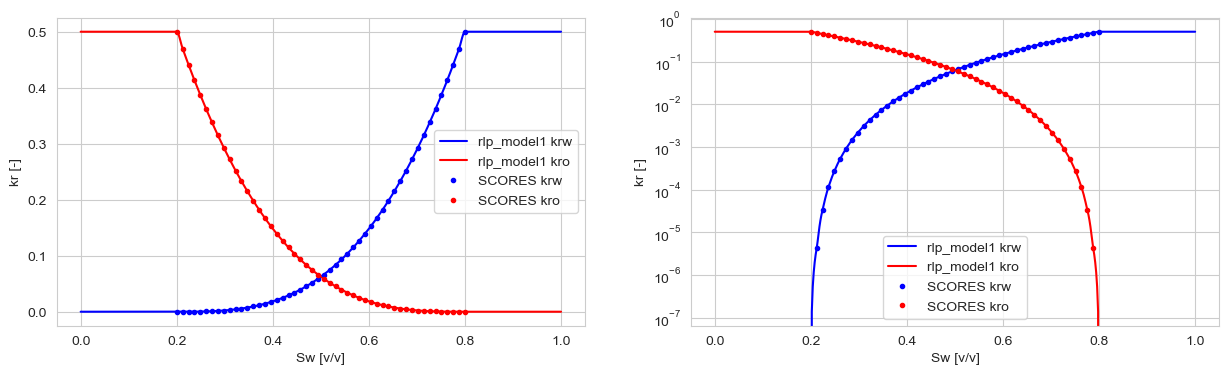

In [10]:
swv = np.linspace(0,1,501) # Sw values to plot rlp_model1

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( swv, rlp_model1.calc_kr1( swv ), 'b', label='rlp_model1 krw')
plt.plot( swv, rlp_model1.calc_kr2( swv ), 'r', label='rlp_model1 kro')

plt.plot( scores.sw_krw.Sw, scores.sw_krw.krw, 'b.', label='SCORES krw')
plt.plot( scores.sw_kro.Sw, scores.sw_kro.kro, 'r.', label='SCORES kro')

plt.xlabel('Sw [v/v]')
plt.ylabel('kr [-]')

plt.legend();

plt.subplot(1,2,2)
plt.plot( swv, rlp_model1.calc_kr1( swv ), 'b', label='rlp_model1 krw')
plt.plot( swv, rlp_model1.calc_kr2( swv ), 'r', label='rlp_model1 kro')

plt.plot( scores.sw_krw.Sw, scores.sw_krw.krw, 'b.', label='SCORES krw')
plt.plot( scores.sw_kro.Sw, scores.sw_kro.kro, 'r.', label='SCORES kro')

plt.xlabel('Sw [v/v]')
plt.ylabel('kr [-]')

plt.legend();
plt.yscale('log');

## Define a water Pc model based on SCORES tabular data

- we use monotonic cubic interpolation of the tabular data, i.e., CubicInterpolator from rlplib

In [11]:
cpr_model1 = rlplib.CubicInterpolator( scores.sw_pc.Sw.values, # v/v
                                       scores.sw_pc.Pc.values, # bar
                                       lex=0, # no left extrapolation
                                       rex=0, # no right extrapolation
                                     );

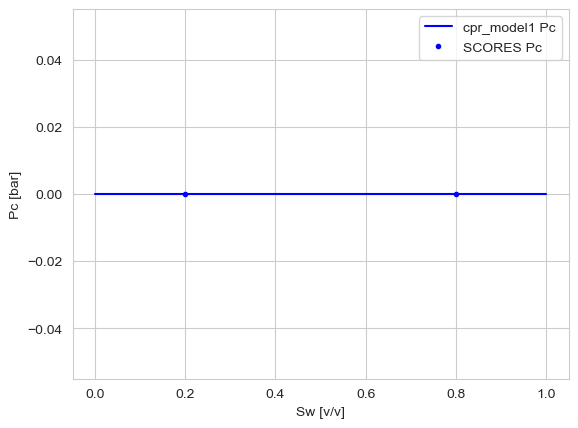

In [12]:
swv = np.linspace(0,1,501) # Sw values to plot cpr_model1

plt.plot( swv, cpr_model1.calc( swv )[0], 'b', label='cpr_model1 Pc')
plt.plot( scores.sw_pc.Sw, scores.sw_pc.Pc, 'b.', label='SCORES Pc');

plt.xlabel('Sw [v/v]')
plt.ylabel('Pc [bar]')

plt.legend();

# Simulate the experiment using SCORES parameters

## The time schedule for simulation is taken from SCORES

In [13]:
scores.schedule

,StartTime,InjRate,FracFlow
0,0.0,3.333333,1.0


## Solve using 1D2P

First set up the model, then solve it. We take 'movie' snapshots at the times specified in the SCORES result_data table.

In [14]:
model1 = DisplacementModel1D2P(    
    NX             = scores.Gridblocks,
    core_length    = scores.Core_length, # cm
    core_area      = scores.Core_area, # cm2
    permeability   = scores.Permeability, # mDarcy
    porosity       = scores.Porosity, # v/v
    sw_initial     = scores.Swi, # v/v
    viscosity_w    = scores.Water_visc, # cP
    viscosity_n    = scores.Oil_visc, # cP
    density_w      = scores.Water_density, # kg/m3
    density_n      = scores.Oil_density, # kg/m3
    rlp_model      = rlp_model1,
    cpr_model      = cpr_model1,
    time_end       = scores.T_end_HOUR, # hour
    rate_schedule  = scores.schedule,
    movie_schedule = scores.result_data.Time.values, # hour
    gravity_multiplier = scores.gravity_multiplier, # 0 when horizonal 1 when vertical
 );

Now solve the model and retrieve results:

In [15]:
results = model1.solve().results

# Compare 1D2P outcome to SCORES results

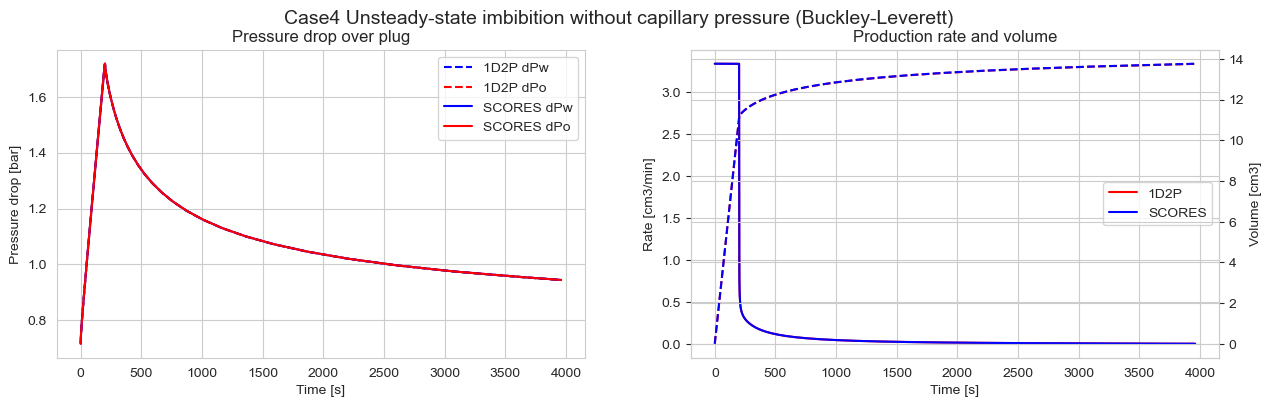

In [16]:
plt.figure(figsize=(15,4))

plt.suptitle(CASE_LABEL,fontsize=14)

plt.subplot(1,2,1)
plt.plot( results.tss_table.TIME*3600, results.tss_table.delta_P_w, 'b--', label='1D2P dPw')
plt.plot( results.tss_table.TIME*3600, results.tss_table.delta_P_o, 'r--', label='1D2P dPo')

plt.plot( scores.result_data.Time*3600, scores.result_data.Delta_Pwat, 'b', label='SCORES dPw');
plt.plot( scores.result_data.Time*3600, scores.result_data.delta_Poil, 'r', label='SCORES dPo');

plt.legend()
plt.xlabel('Time [s]');
plt.ylabel('Pressure drop [bar]')
plt.title('Pressure drop over plug');

plt.subplot(1,2,2)

plt.plot( results.tss_table.TIME*3600, results.tss_table.OILProd, 'r', label='1D2P')
plt.plot( scores.result_data.Time*3600, scores.result_data.qoil_prod, 'b', label='SCORES')

plt.xlabel('Time [s]'); plt.ylabel('Rate [cm3/min]');
plt.title('Production rate and volume')
plt.legend(loc='center right');
plt.twinx()

plt.plot( results.tss_table.TIME*3600, results.tss_table.CumOIL, 'r--')
plt.plot( scores.result_data.Time*3600,  scores.result_data.Noil_prod, 'b--')

plt.ylabel('Volume [cm3]');

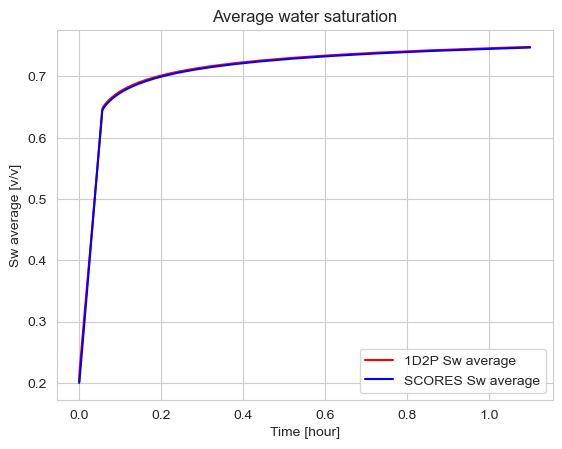

In [17]:
plt.plot(results.movie_time, results.movie_sw.mean(axis=1), 'r', label='1D2P Sw average')

plt.plot( scores.result_data.Time, scores.result_data.Meansat, 'b', label='SCORES Sw average' );

plt.xlabel('Time [hour]')
plt.ylabel('Sw average [v/v]');

plt.title('Average water saturation')
plt.legend();

# Conclusion

1D2P is in line with literature data, 1D2P and SCORES give identical results.

## Solver performance

For information of 1D2P solver performance, the plots below give a summary of Newton iterations and simulation timestep sizes:

- the 1D2P solver uses 3 Newton iterations to solve a timestep
- the timestep size is dictated by the movie_schedule, i.e., there are no timestep cutbacks due to Newton solver problems

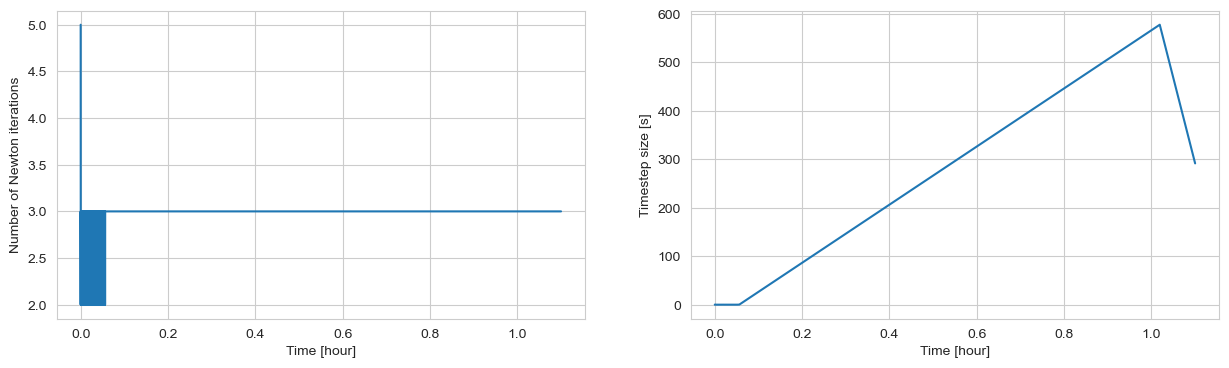

In [18]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(results.tss_table.TIME, results.movie_nr)
plt.xlabel('Time [hour]')
plt.ylabel('Number of Newton iterations')

plt.subplot(1,2,2)

plt.plot(results.tss_table.TIME, results.tss_table.DTIME*3600)
plt.xlabel('Time [hour]')
plt.ylabel('Timestep size [s]');